In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from scipy.signal import convolve2d as conv2
from scipy.fft import fft2, ifft2
from skimage.util import random_noise
from skimage.restoration import wiener, richardson_lucy

# helper function for forward operator
def K(inp,psf=[],mode='forward'):
    n = inp.shape[0]
    k_hat = fft2(psf,s=(n,n))
    inp_hat = fft2(inp)
    if mode == 'forward':
        outp = ifft2(k_hat * inp_hat)
    if mode == 'adjoint':
        outp = ifft2(np.conj(k_hat) * inp_hat)
    if mode == 'inv':
        outp = ifft2( np.conj(k_hat) * inp_hat / ( np.conj(k_hat) * k_hat + 1e-16) )
        
    return np.real(outp)

# helper function for plotting
def plot_images(images, titles, fname=[], scale = [0,1]):
    m = len(images)
    fig, ax = plt.subplots(1,m)
    
    if m > 1:
        for k in range(m):
            ax[k].set_xticks([])
            ax[k].set_yticks([])
            ax[k].imshow(images[k], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
            ax[k].set_title(titles[k])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[0], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
        ax.set_title(titles[0])
    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)

# Regularisation with linear filters

To avoid amplification of noise, we need to regularise the inverse filter.

Wiener filter:

$$\widetilde{u}^\delta_\alpha = \mathcal{F}^{-1} \left(\frac{\widehat{k}^*\widehat{f}^\delta}{|\widehat{k}|^2 + \alpha |\widehat{r}|^2}\right),$$

where $\widehat{r}$ is the psf of the regularistation operator.

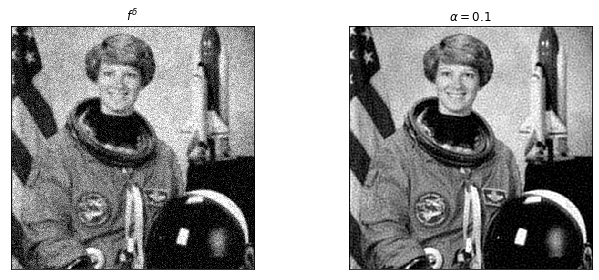

In [24]:
# read image
u = rgb2gray(data.astronaut())

# blur image
kernel = np.ones((5, 5)) / 25
f = K(u,psf = kernel)

# add_noise
delta = 0.1
f_delta = f + delta * np.random.randn(f.shape[0],f.shape[1])

# regularisation
reg_psf = np.array([[0,0,0],[0,1,0],[0,0,0]])
reg_psf = np.array([[0,1,0],[1,-4,1],[0,1,0]])

# apply inverse
alpha = 1e-1
u_est = wiener(f_delta, psf = kernel, reg = reg_psf, balance=alpha, clip=False) 

plot_images([f_delta, u_est], [r'$f^\delta$',r'$\alpha = $'+ str(alpha)])

## Bias-variance trade-off

Regularisation reduces the influence of noise but introduces a bias.

$$\|u^\delta_\alpha - u\| \leq \|u^0_\alpha - u\| + \|u^\delta_\alpha - u^0_\alpha\|.$$

In [25]:
def bias_variance_plot(delta, alphas):
    # read image
    u = rgb2gray(data.astronaut())

    # blur image
    psf = np.ones((5, 5)) / 25
    f   = K(u,psf = kernel)

    # add_noise
    f_delta = f + delta * np.random.randn(f.shape[0],f.shape[1])
    
    # regularisation
    reg_psf = np.array([[0,0,0],[0,1,0],[0,0,0]])

    # apply inverse
    ns       = len(alphas)
    error    = np.zeros(ns)
    bias     = np.zeros(ns)
    variance = np.zeros(ns)

    for k in range(ns):
        u_delta_alpha = wiener(f_delta, psf, reg = reg_psf, balance=alphas[k], clip=False) 
        u_0_alpha     = wiener(f,       psf, reg = reg_psf, balance=alphas[k], clip=False)

        error[k]    = np.linalg.norm(u_delta_alpha - u            ) / np.linalg.norm(u)
        bias[k]     = np.linalg.norm(u_0_alpha     - u            ) / np.linalg.norm(u)
        variance[k] = np.linalg.norm(u_0_alpha     - u_delta_alpha) / np.linalg.norm(u)

    plt.plot(alphas,error,label='total error')
    plt.plot(alphas,bias,label='bias')
    plt.plot(alphas,variance,label='variance')
    plt.legend()
    plt.xlabel(r'$\alpha$')
    plt.ylabel('rel. error')

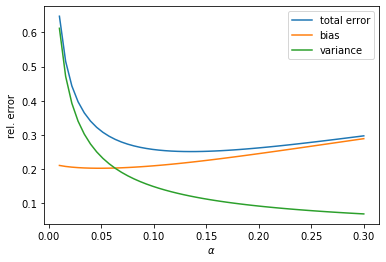

In [26]:
# plot
delta  = .1
alphas = np.linspace(.01,.3,50)
bias_variance_plot(delta, alphas)

# A variational framework

The above-mentioned regularisation methods can be cast as a least-squares problem

$$\min_u \frac{1}{2\delta^2}\|Ku - f^\delta\|_2^2 + \frac{1}{2\lambda^2} \|Ru\|_2^2,$$

with $\alpha = (\delta / \lambda)^2$.

This quadratic problem has a closed-form solution

$${u}^\delta_\alpha = \left(K^*\!K + \alpha R^*\!R\right)^{-1}K^*f^\delta.$$

# A statistical interpretation

The solution can be interpreted as the most likely one, under the assumption that 

* $f^\delta = Ku + \epsilon$, with $\epsilon \sim \mathcal{N}(0,\delta^2)$
* $u \sim \mathcal{N}(0,\lambda (R^*\!R)^{-1})$.

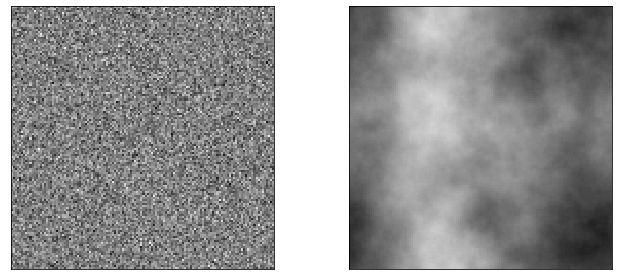

In [34]:
n = 128

# regularisation
reg_psf = np.array([[0,1,0],[1,-4,1],[0,1,0]])*n

# random image with diagonal covariance
u1 = .05*np.random.randn(n,n)

# random image with inverse Laplace covariance
z = np.random.randn(n,n)
u2 = K(z, psf = reg_psf, mode='inv')
#
plot_images([u1,u2], ['',''], scale=[-.2,.2])

The link with the previous least-squares formulation is the *Maximum Likelihood estimate*:

$$\max_u \exp\left(\frac{1}{2\delta^2} \|Ku - f^\delta\|_2^2\right)\exp\left(\frac{1}{2\lambda} \|Ru\|_2^2\right).$$

Other noise models are possible as well, with *Poisson noise* being popular for many imaging applications:

$$f^\delta \sim \text{Poisson}(Ku),$$

which leads to

$$\max_u \left(\prod_{i=1}^n \left(Ku\right)_i^{f^\delta_i} \exp\left(-(Ku)_i\right)\right)\exp\left(\frac{1}{2\lambda} \|Ru\|_2^2\right),$$

or

$$\min_u \sum_{i=1}^n f^\delta_i \log\left(Ku\right)_i - \left(Ku\right)_i + \frac{1}{2\lambda} \|Ru\|_2^2.$$

# Assignment: iterative deconvolution

One can solve the *unregularised* least-squares problem in an iterative fashion

$$u_{k+1} = u_k - \alpha K^*\!\left(Ku_k - f^\delta\right),$$

where $\alpha \in (0,1/\|K\|_2)$

* Pick a suitable value for $\alpha$ and investigate what happens during the iterations. Does the initial iterate make a difference in the performance of the method?
* Make a bias-variance plot as function of the iteration count. Can we say that the iteration count acts as a regularisation parameter?
* What would you consider the optimal value of the regularisation parameter? Could you think of a way to estimate it given that you know the actual noise level?

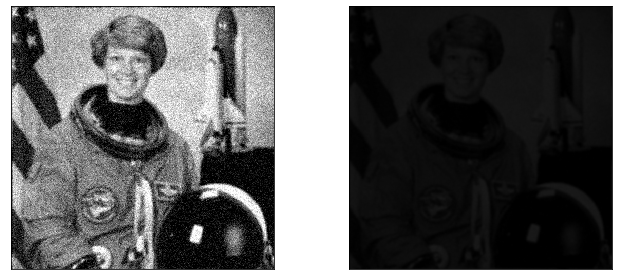

In [13]:
# iterative decon
def it_decon(f, psf, alpha, niter):
    u = 0*f
    for _ in range(niter):
        r = K(u, psf, mode='forward') - f
        u -= alpha * K(r, psf, mode='adjoint')
    return u

# read image
u = rgb2gray(data.astronaut())
    
# blur
psf = np.ones((5, 5)) / 25
f   = K(u,psf)

# add_noise
f_delta = f + delta * np.random.randn(f.shape[0],f.shape[1])

# decon
u_est = it_decon(f_delta, psf, .01, 10)

# plot
plot_images([f_delta,u_est], ['',''])